In [ ]:
!pip install transformers datasets torchvision
!pip install "diffusers[torch]" 


## Model finetuning - DreamBooth

### Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from diffusers import StableDiffusionPipeline
from transformers import CLIPTokenizer
from datasets import load_dataset
from tqdm import tqdm



/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading the dataset + preprocessing

Here, we load the dataset "huggan/wikiart" from hugging face.
we filter the dataset to a single artist, in this case Claude Monet but I also generated previously Van Gough images.

In [3]:
# Load the full WikiArt dataset from HugGAN
dataset = load_dataset("huggan/wikiart", split="train",streaming=True)

# Filter by artist ID(claude monet) with tqdm
artist_id = 4
filtered = []

# Limit tqdm bar to something large but finite (streaming doesn't give length)
for sample in tqdm(dataset, desc=f"Filtering artist_id={artist_id}", total=100_000):
    if sample["artist"] == artist_id:
        filtered.append(sample)


Filtering artist_id=4:  81%|████████▏ | 81444/100000 [17:09<03:54, 79.12it/s]  


### Saving the subject images
in dreambooth we use the subject images for the finetuning and prior images for prior preservation - meaning, we don't want the model to forget it original class as we see further ahead.

here, we save each image of the artist we choose.

In [ ]:
# --- get subject images ---
sub_dir = "subject_images"
os.makedirs(sub_dir, exist_ok=True)

for idx, sample in enumerate(filtered):
    image = sample["image"]  
    assert isinstance(image, Image.Image), f"Item {idx} is not a PIL image"

    artist = sample.get("artist", "unknown")
    genre = sample.get("genre", "unknown")
    style = sample.get("style", "unknown")

    filename = f"img_{idx:05d}_artist{artist}_genre{genre}_style{style}.jpg"
    filepath = os.path.join(sub_dir, filename)

    image.save(filepath)

print(f"✅ Saved {len(filtered)} images to '{sub_dir}/'")

✅ Saved 1334 images to 'subject_images/'


In [3]:
device = "cuda"

### Loading our base model
We are using here the stable diffusion model from "stable-diffusion-v1-5/stable-diffusion-v1-5", since DreamBooth requires the use of the tokenizer and requires a prompt, something we didn't implement in our original model.

In [ ]:
# ----- Load pretrained Stable Diffusion -----
model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(device)
tokenizer: CLIPTokenizer = pipe.tokenizer


Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


### Creating a unique token
DreamBooth requires us to create a unique token to the tokenizer's vocab.
here, we choose the token "[skaz]", but it could be anything new.

we added the token, resize the vocab, and get the unique token embedding and class embedding.

In [5]:
# ----- Add a new token -----
new_token = "[skaz]"
class_token = "artwork"
num_added = tokenizer.add_tokens([new_token])
pipe.text_encoder.resize_token_embeddings(len(tokenizer))
new_token_id = tokenizer.convert_tokens_to_ids(new_token)

# we use class token in order to avoid drift, as mentioned in the dreambooth paper.
class_token_id = tokenizer.convert_tokens_to_ids(class_token)

In [6]:
num_added

1

### Weight freezing
here, we freeze the weights of the entire model except the UNet and text encoder, and add learning rates for the unet params and the embedding layer and define our optimizer.

In [7]:
# ----- fine-tune new token embedding -----
embedding_layer = pipe.text_encoder.get_input_embeddings()

# Freeze all text encoder params
for param in pipe.text_encoder.parameters():
    param.requires_grad = False

# Unfreeze the embedding weights and unet weights
embedding_layer.weight.requires_grad = True
pipe.unet.requires_grad_(True)

optimizer = torch.optim.Adam([
    {"params": pipe.unet.parameters(),"lr": 1e-7},
    {"params": [embedding_layer.weight], "lr": 5e-4}
], lr=5e-4)


### Data preprocessing
here, we process the image - resize them to 512x512, and normalize to be between 1 to -1.

In [8]:
transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

### Dataset 
here, we define a custom dataset by defining the 3 magic function - __init__, __len__, __getitem__.
we take from our image folder each image.

if we run out of images in either the prior or the subject we wrap around and train on existing images, and load the data using the transformation given as a param.

In [9]:
class SimpleDreamBoothDataset(Dataset):
    def __init__(self, subject_dir, prior_dir, transform):
        # build full paths, and only keep files
        self.subject_images = [
            os.path.join(subject_dir, f)
            for f in os.listdir(subject_dir)
            if os.path.isfile(os.path.join(subject_dir, f))
        ]
        self.prior_images = [
            os.path.join(prior_dir, f)
            for f in os.listdir(prior_dir)
            if os.path.isfile(os.path.join(prior_dir, f))
        ]
        self.transform = transform

    def __len__(self):
        # so we cycle through the smaller set repeatedly
        return max(len(self.subject_images), len(self.prior_images))

    def __getitem__(self, idx):
        # wrap around
        subj_path  = self.subject_images[idx % len(self.subject_images)]
        prior_path = self.prior_images[idx % len(self.prior_images)]

        # open & ensure RGB
        img_subj  = Image.open(subj_path).convert("RGB")
        img_prior = Image.open(prior_path).convert("RGB")

        return self.transform(img_subj), self.transform(img_prior)


In [12]:
class_prompt = "A painting in the style of Claude Monet"
num_images = 400
pri_dir = "prior_images"
os.makedirs(pri_dir, exist_ok=True)

### Generating the prior images
here, we use our base model to generate a close rep. of our class token, since we want to preserve it, we generate ``` num_images ``` unique images and save them.

dreambooth does backpropagation on the entire UNet and text encoder, so similar represention might "drift", so we also strengthen the model's preception of the class rep. that is close to it. 

In [ ]:
for i in range(num_images):
    if i % 10 == 0:
        print(f"generating prior image #{i}")
    image = pipe(class_prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
    image.save(os.path.join(pri_dir, f"class_image_{i:03}.png"))

### Loading the data

In [10]:
dataset = SimpleDreamBoothDataset("subject_images", "prior_images",transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

### Training

first, we define training params.
then we tokenize subject, prior prompts, and we encode both prompts.
we encode both in the VAE.

now we have a latent rep. we take alpha(how much of the signal is preserved), sigma(how much noise is applied) at time ``` t ```. 
we then multiply alpha by the latent and sigma by the noise - creating an noisy image at a random timestep.(if t is close to end very noisy and if close to the start then slightly noisy).

we insert into the UNet the noisy latent of the subject and prior, predict their noise and preform Mean Squared Error on both of them.

using backpropigation, we adjust the weights.


In [11]:
from torch.cuda.amp import GradScaler, autocast
import torch.nn.functional as F

# ----- Training loop -----
num_epochs = 1000
lmbda = 1.0  # prior preservation weight
pipe.unet.to(torch.float32)

for step, (x_subj, x_prior) in enumerate(dataloader):
    if step >= num_epochs:
        break

    # Move to device
    x_subj = x_subj.to(device)
    x_prior = x_prior.to(device)

    # --- Tokenize prompts ---
    subj_prompt  = f"a photo of {new_token} {class_token}"
    prior_prompt = f"a photo of {class_token}"
    subj_ids  = tokenizer(subj_prompt,  return_tensors="pt").input_ids.to(device)
    prior_ids = tokenizer(prior_prompt, return_tensors="pt").input_ids.to(device)

    # --- Text embeddings (frozen) ---
    with torch.no_grad():
        subj_embeds  = pipe.text_encoder(subj_ids)[0]
        prior_embeds = pipe.text_encoder(prior_ids)[0]

    # --- Encode RGB images → 4-channel latents (float16) ---
    with torch.no_grad():
        x_subj_fp16  = x_subj.to(torch.float16)
        x_prior_fp16 = x_prior.to(torch.float16)

        latents_subj  = pipe.vae.encode(x_subj_fp16).latent_dist.sample()
        latents_prior = pipe.vae.encode(x_prior_fp16).latent_dist.sample()

        latents_subj  *= pipe.vae.config.scaling_factor
        latents_prior *= pipe.vae.config.scaling_factor

    # --- Noise injection ---
    noise = torch.randn_like(latents_subj)
    batch_size = latents_subj.shape[0]
    t = torch.randint(
        0,
        pipe.scheduler.config.num_train_timesteps,
        (batch_size,),
        device=device,
    ).long()

    alphas = pipe.scheduler.alphas_cumprod.to(device)
    alpha_t = alphas[t].view(-1, 1, 1, 1).sqrt()
    sigma_t = (1 - alphas[t]).view(-1, 1, 1, 1).sqrt()

    noisy_subj  = alpha_t * latents_subj  + sigma_t * noise
    noisy_prior = alpha_t * latents_prior + sigma_t * noise

    # --- Forward + Loss (mixed precision) ---
    scaler = GradScaler()
    with autocast():
        pred_subj  = pipe.unet(noisy_subj,  t, encoder_hidden_states=subj_embeds).sample
        pred_prior = pipe.unet(noisy_prior, t, encoder_hidden_states=prior_embeds).sample

        loss_subj  = F.mse_loss(pred_subj,  noise)
        loss_prior = F.mse_loss(pred_prior, noise)
        loss = loss_subj + lmbda * loss_prior + 1e-8

    # --- Backprop & optimize ---
    scaler.scale(loss).backward()
    scaler.unscale_(optimizer)  # allow grad clipping
    torch.nn.utils.clip_grad_norm_(pipe.unet.parameters(), 1.0)
    scaler.step(optimizer)
    scaler.update()
    
    optimizer.zero_grad()

    if step % 10 == 0:
        print(
            f"[{step:04d}] "
            f"Loss: {loss.item():.4f} | "
            f"Subj: {loss_subj.item():.4f} | "
            f"Prior: {loss_prior.item():.4f}"
        )


/usr/local/lib/python3.8/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


[0000] Loss: 1.2375 | Subj: 0.7369 | Prior: 0.5006
[0010] Loss: 1.3691 | Subj: 0.6774 | Prior: 0.6916
[0020] Loss: 0.4406 | Subj: 0.2291 | Prior: 0.2115
[0030] Loss: 0.4630 | Subj: 0.2221 | Prior: 0.2410
[0040] Loss: 0.7395 | Subj: 0.3627 | Prior: 0.3768
[0050] Loss: 0.6079 | Subj: 0.3052 | Prior: 0.3028
[0060] Loss: 0.3357 | Subj: 0.1786 | Prior: 0.1571
[0070] Loss: 1.1967 | Subj: 0.6245 | Prior: 0.5723
[0080] Loss: 0.0246 | Subj: 0.0118 | Prior: 0.0128
[0090] Loss: 0.6883 | Subj: 0.3385 | Prior: 0.3499
[0100] Loss: 0.0278 | Subj: 0.0129 | Prior: 0.0149
[0110] Loss: 0.3858 | Subj: 0.1820 | Prior: 0.2037
[0120] Loss: 0.8055 | Subj: 0.4604 | Prior: 0.3451
[0130] Loss: 0.3447 | Subj: 0.1905 | Prior: 0.1542
[0140] Loss: 0.0948 | Subj: 0.0320 | Prior: 0.0628
[0150] Loss: 0.0644 | Subj: 0.0270 | Prior: 0.0374
[0160] Loss: 0.6121 | Subj: 0.3031 | Prior: 0.3090
[0170] Loss: 0.0179 | Subj: 0.0065 | Prior: 0.0114
[0180] Loss: 1.4158 | Subj: 0.7285 | Prior: 0.6873
[0190] Loss: 0.4893 | Subj: 0.2

### Utility function
here, we define a function to generate our new images from the fine tuned model.

In [15]:
def generate_skax_images(prompt, num_images=1, guidance_scale=7.5, num_inference_steps=100, height=512, width=512):
    with autocast(dtype=torch.float16):
        output = pipe(
            prompt,
            height=height,
            width=width,
            num_images_per_prompt=num_images,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps,
        )
    return output.images

### Generation
we can now generate our desired image in our fine tuned model, great!

In [42]:
prompt = "dogs playing in the lush grass, and kids running. drawn like a [skaz] painting"
imgs = generate_skax_images(prompt,num_images=5)

100%|██████████| 100/100 [00:04<00:00, 20.33it/s]


### Saving generated images to disk

In [43]:
for idx, img in enumerate(imgs):
    img.save(f"skaz_{prompt.replace('[skaz]' ,'skaz').replace(' ','_')}_{idx}.png")


### Saving the weights of the model

In [63]:
# save fine-tuned dreambooth model.
output_dir = "dreambooth_skax_finetuned"
pipe.save_pretrained(output_dir)

### Results

* prompt: make a [skaz] drawing of A hazy harbor at dawn, with a orange sun rising over calm water. Small boats float,while ships and masts fade into the misty background, blurring the line between sky and sea. drawn like [skaz]

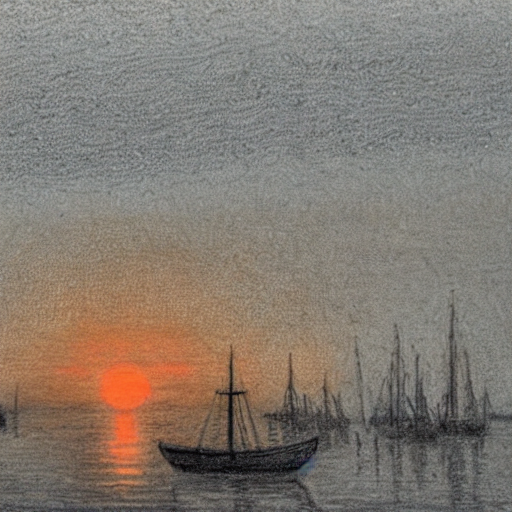

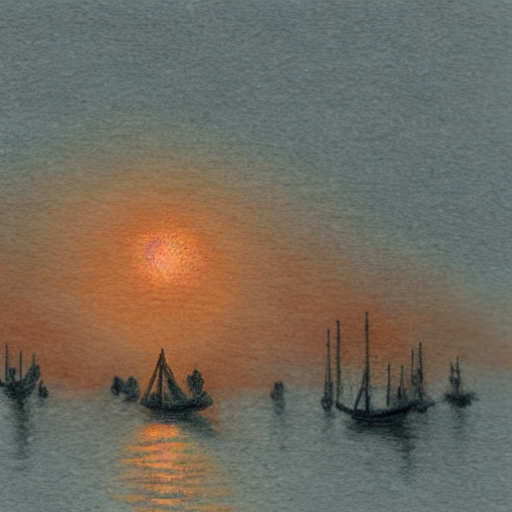



* prompt: [skaz] dogs playing in the lush grass, and kids running. drawn like a [skaz] painting

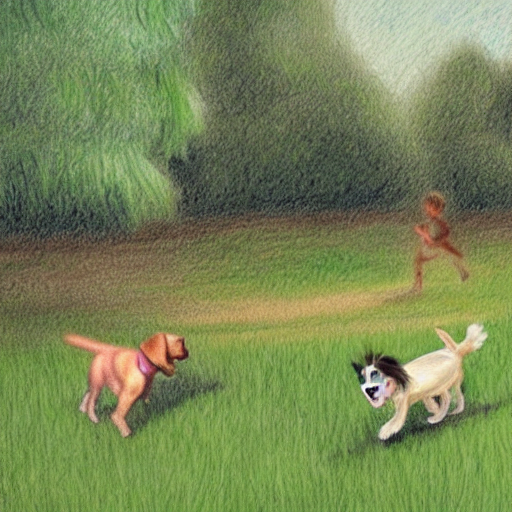

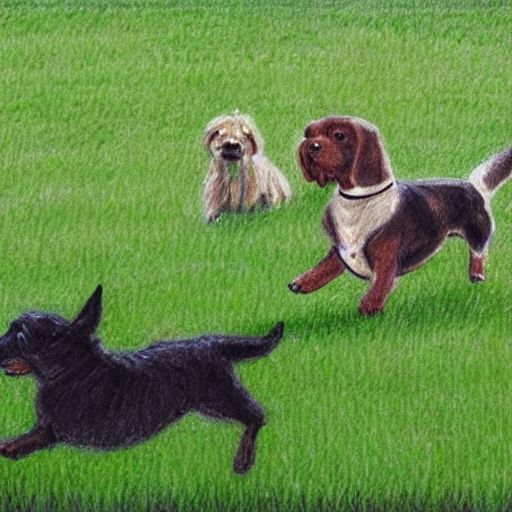

* prompt: [skaz] drawing with a grass near the lake and people setting next to it drawn like [skaz]

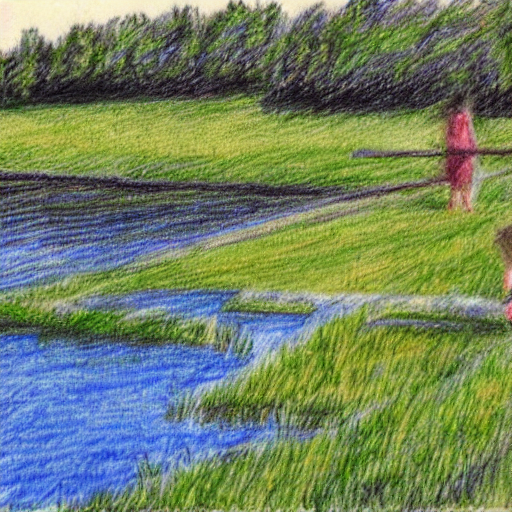

* prompt: [skaz] image with a man portrait where an apple hides his face. in the background their should be an empty canvas. should be drawn like [skaz] painting

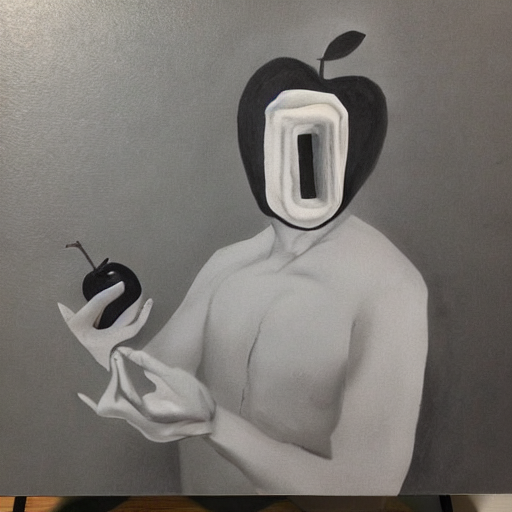